In [1]:
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

quantity_cols = [name + f'_{i}' for name in ['ask_quantity', 'bid_quantity'] for i in range(10)]

dfs = []
for i in range(1, 4):
    df = pl.read_csv('C:/Users/Riccardo/Documents/TTF_all/TTF_M' + str(i) + '/minute_aggregation_order.csv')
    df = df.with_columns(
        pl.col('timestamp').str.to_datetime().alias('timestamp'),
        pl.col(quantity_cols).cast(pl.Utf8).str.replace(r"\..*$", "").str.replace(r"^None$", '').cast(pl.Int64, strict=False)
    ).with_columns(
        [(pl.col("prod").str.to_date("%b-%y", strict=False).dt.offset_by('-1mo').dt.month_end().sub(
                    pl.col("timestamp").dt.date()).dt.total_days().alias('days_to_roll'))] +
        [pl.sum_horizontal(quantity_cols).alias('total_quantity')] +
        [pl.col('ask_quantity_0').add(pl.col('bid_quantity_0').truediv(2)).alias('mid_vol_0')] + 
        [pl.col('ask_0').sub(pl.col('bid_0')).alias('spread_0')] +
        [(pl.col('ask_0').add(pl.col('bid_0')).truediv(2)).diff().abs().alias('abs_delta_0')] +
        [pl.col('timestamp').dt.hour().alias('hour')]
    ).sort('timestamp').select(['days_to_roll', 'hour', 'prod', 'total_quantity', 'mid_vol_0', 'spread_0', 'abs_delta_0'])
    
    dfs.append(df)
    
df = pl.concat(dfs)



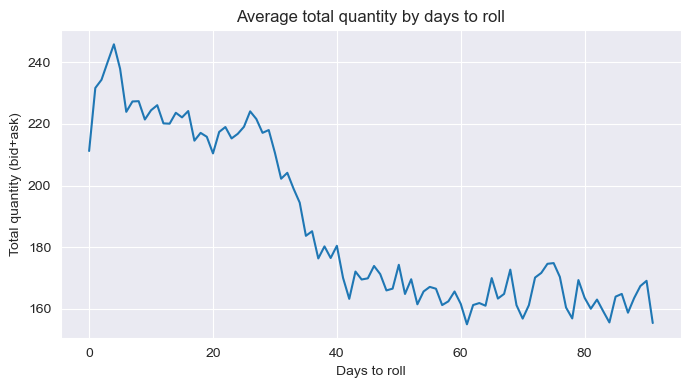

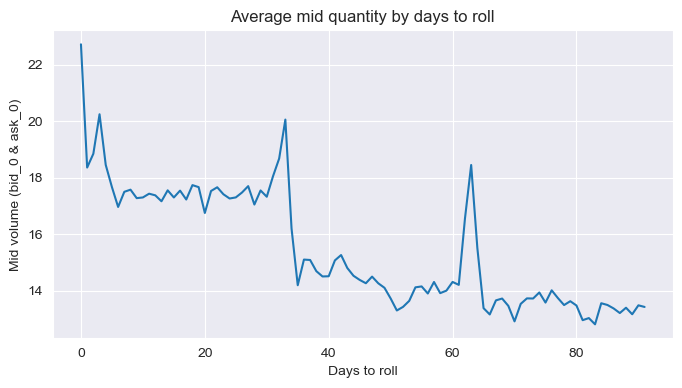

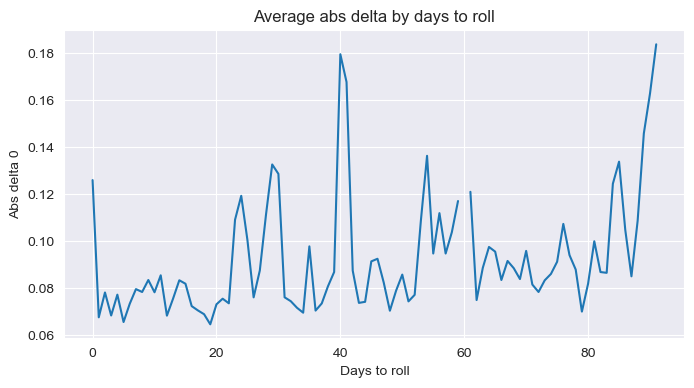

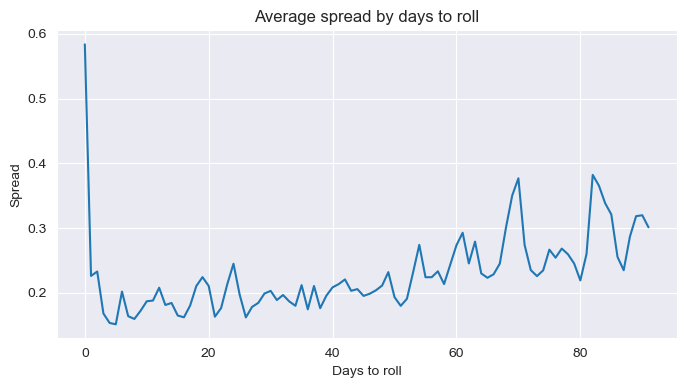

In [7]:

df_union = (df.sort('days_to_roll').group_by('days_to_roll')
    .agg(
        pl.col("total_quantity").mean().alias("avg_quantity")
    )
)

plt.figure(figsize=(8,4))
plt.plot(df_union['days_to_roll'], df_union['avg_quantity'])
plt.xlabel('Days to roll')
plt.ylabel('Total quantity (bid+ask)')
plt.title('Average total quantity by days to roll')
plt.show()

df_union = (df.sort('days_to_roll').group_by('days_to_roll')
    .agg(
        pl.col("mid_vol_0").mean().alias("avg_quantity")
    )
)

plt.figure(figsize=(8, 4))
plt.plot(df_union['days_to_roll'], df_union['avg_quantity'])
plt.xlabel('Days to roll')
plt.ylabel('Mid volume (bid_0 & ask_0)')
plt.title('Average mid quantity by days to roll')
plt.show()

df_union = (df.sort('days_to_roll').group_by('days_to_roll')
    .agg(
        pl.col("abs_delta_0").mean().alias("avg_delta")
    ).with_columns(
        pl.when(pl.col('days_to_roll') == 60).then(None).otherwise(pl.col('avg_delta')).alias('avg_delta')
    )
)

plt.figure(figsize=(8, 4))
plt.plot(df_union['days_to_roll'], df_union['avg_delta'])
plt.xlabel('Days to roll')
plt.ylabel('Abs delta 0')
plt.title('Average abs delta by days to roll')
plt.show()


df_union = (df.sort('days_to_roll').with_columns(
        pl.col('spread_0').clip(lower_bound = 0., upper_bound=2.5).alias('spread_clipped')
    ).group_by('days_to_roll')
    .agg(
        pl.col('spread_clipped').mean().alias("avg_spread_clipped")
    )
).sort('days_to_roll')

plt.figure(figsize=(8, 4))
plt.plot(df_union['days_to_roll'], df_union['avg_spread_clipped'])
plt.xlabel('Days to roll')
plt.ylabel('Spread')
plt.title(f'Average spread by days to roll')
plt.show()

to_show = False
if to_show:
    df_union = (df.sort('days_to_roll').group_by(['prod', 'days_to_roll'])
    .agg(
        pl.col("spread_0").mean().alias("avg_spread"),
    )).sort('days_to_roll')
    prods = df_union['prod'].unique()
    for prod in prods:
        df_temp = df_union.filter(pl.col('prod')==prod).sort('days_to_roll')
        plt.figure(figsize=(8, 4))
        plt.plot(df_temp['days_to_roll'], df_temp['avg_spread'])
        plt.xlabel('Days to roll')
        plt.ylabel('Spread')
        plt.title(f'Average spread by days to roll: {prod}')
        plt.show()

In [14]:
trades = pl.read_csv('C:/Users/Riccardo/Documents/TTF_M+1_Trades_Tick/TTF_M1_trades.csv')
trades

,tradeId,venueCode,dealDate,price,quantity,aggressorBuy,prod,timestamp
i64,str,str,str,f64,f64,bool,str,str
0,"""5049767|5132980|200102 Public""","""ICE""","""2020-01-02""",12.5,30.0,true,"""Feb-20""","""2020-01-02 07:15:32.703"""
1,"""5049794|5132980|200102 Public""","""ICE""","""2020-01-02""",12.5,30.0,true,"""Feb-20""","""2020-01-02 07:15:32.959"""
2,"""5049932|5132980|200102 Public""","""ICE""","""2020-01-02""",12.55,30.0,true,"""Feb-20""","""2020-01-02 07:15:49.223"""
3,"""7146155""","""GRFN""","""2020-01-02""",12.55,30.0,true,"""Feb-20""","""2020-01-02 07:15:52.196"""
5,"""7146312""","""GRFN""","""2020-01-02""",12.55,10.0,true,"""Feb-20""","""2020-01-02 07:15:59.053"""
…,…,…,…,…,…,…,…,…
144583,"""41000012079606|5863238|250312 …","""ICE""","""2025-03-12""",41.885,5.0,true,"""Apr-25""","""2025-03-12 16:59:55.104"""
144582,"""41000012079912|5863238|250312 …","""ICE""","""2025-03-12""",41.88,5.0,true,"""Apr-25""","""2025-03-12 16:59:55.104"""
144584,"""7864322""","""ICAP""","""2025-03-12""",41.845,10.0,false,"""Apr-25""","""2025-03-12 16:59:57.524"""


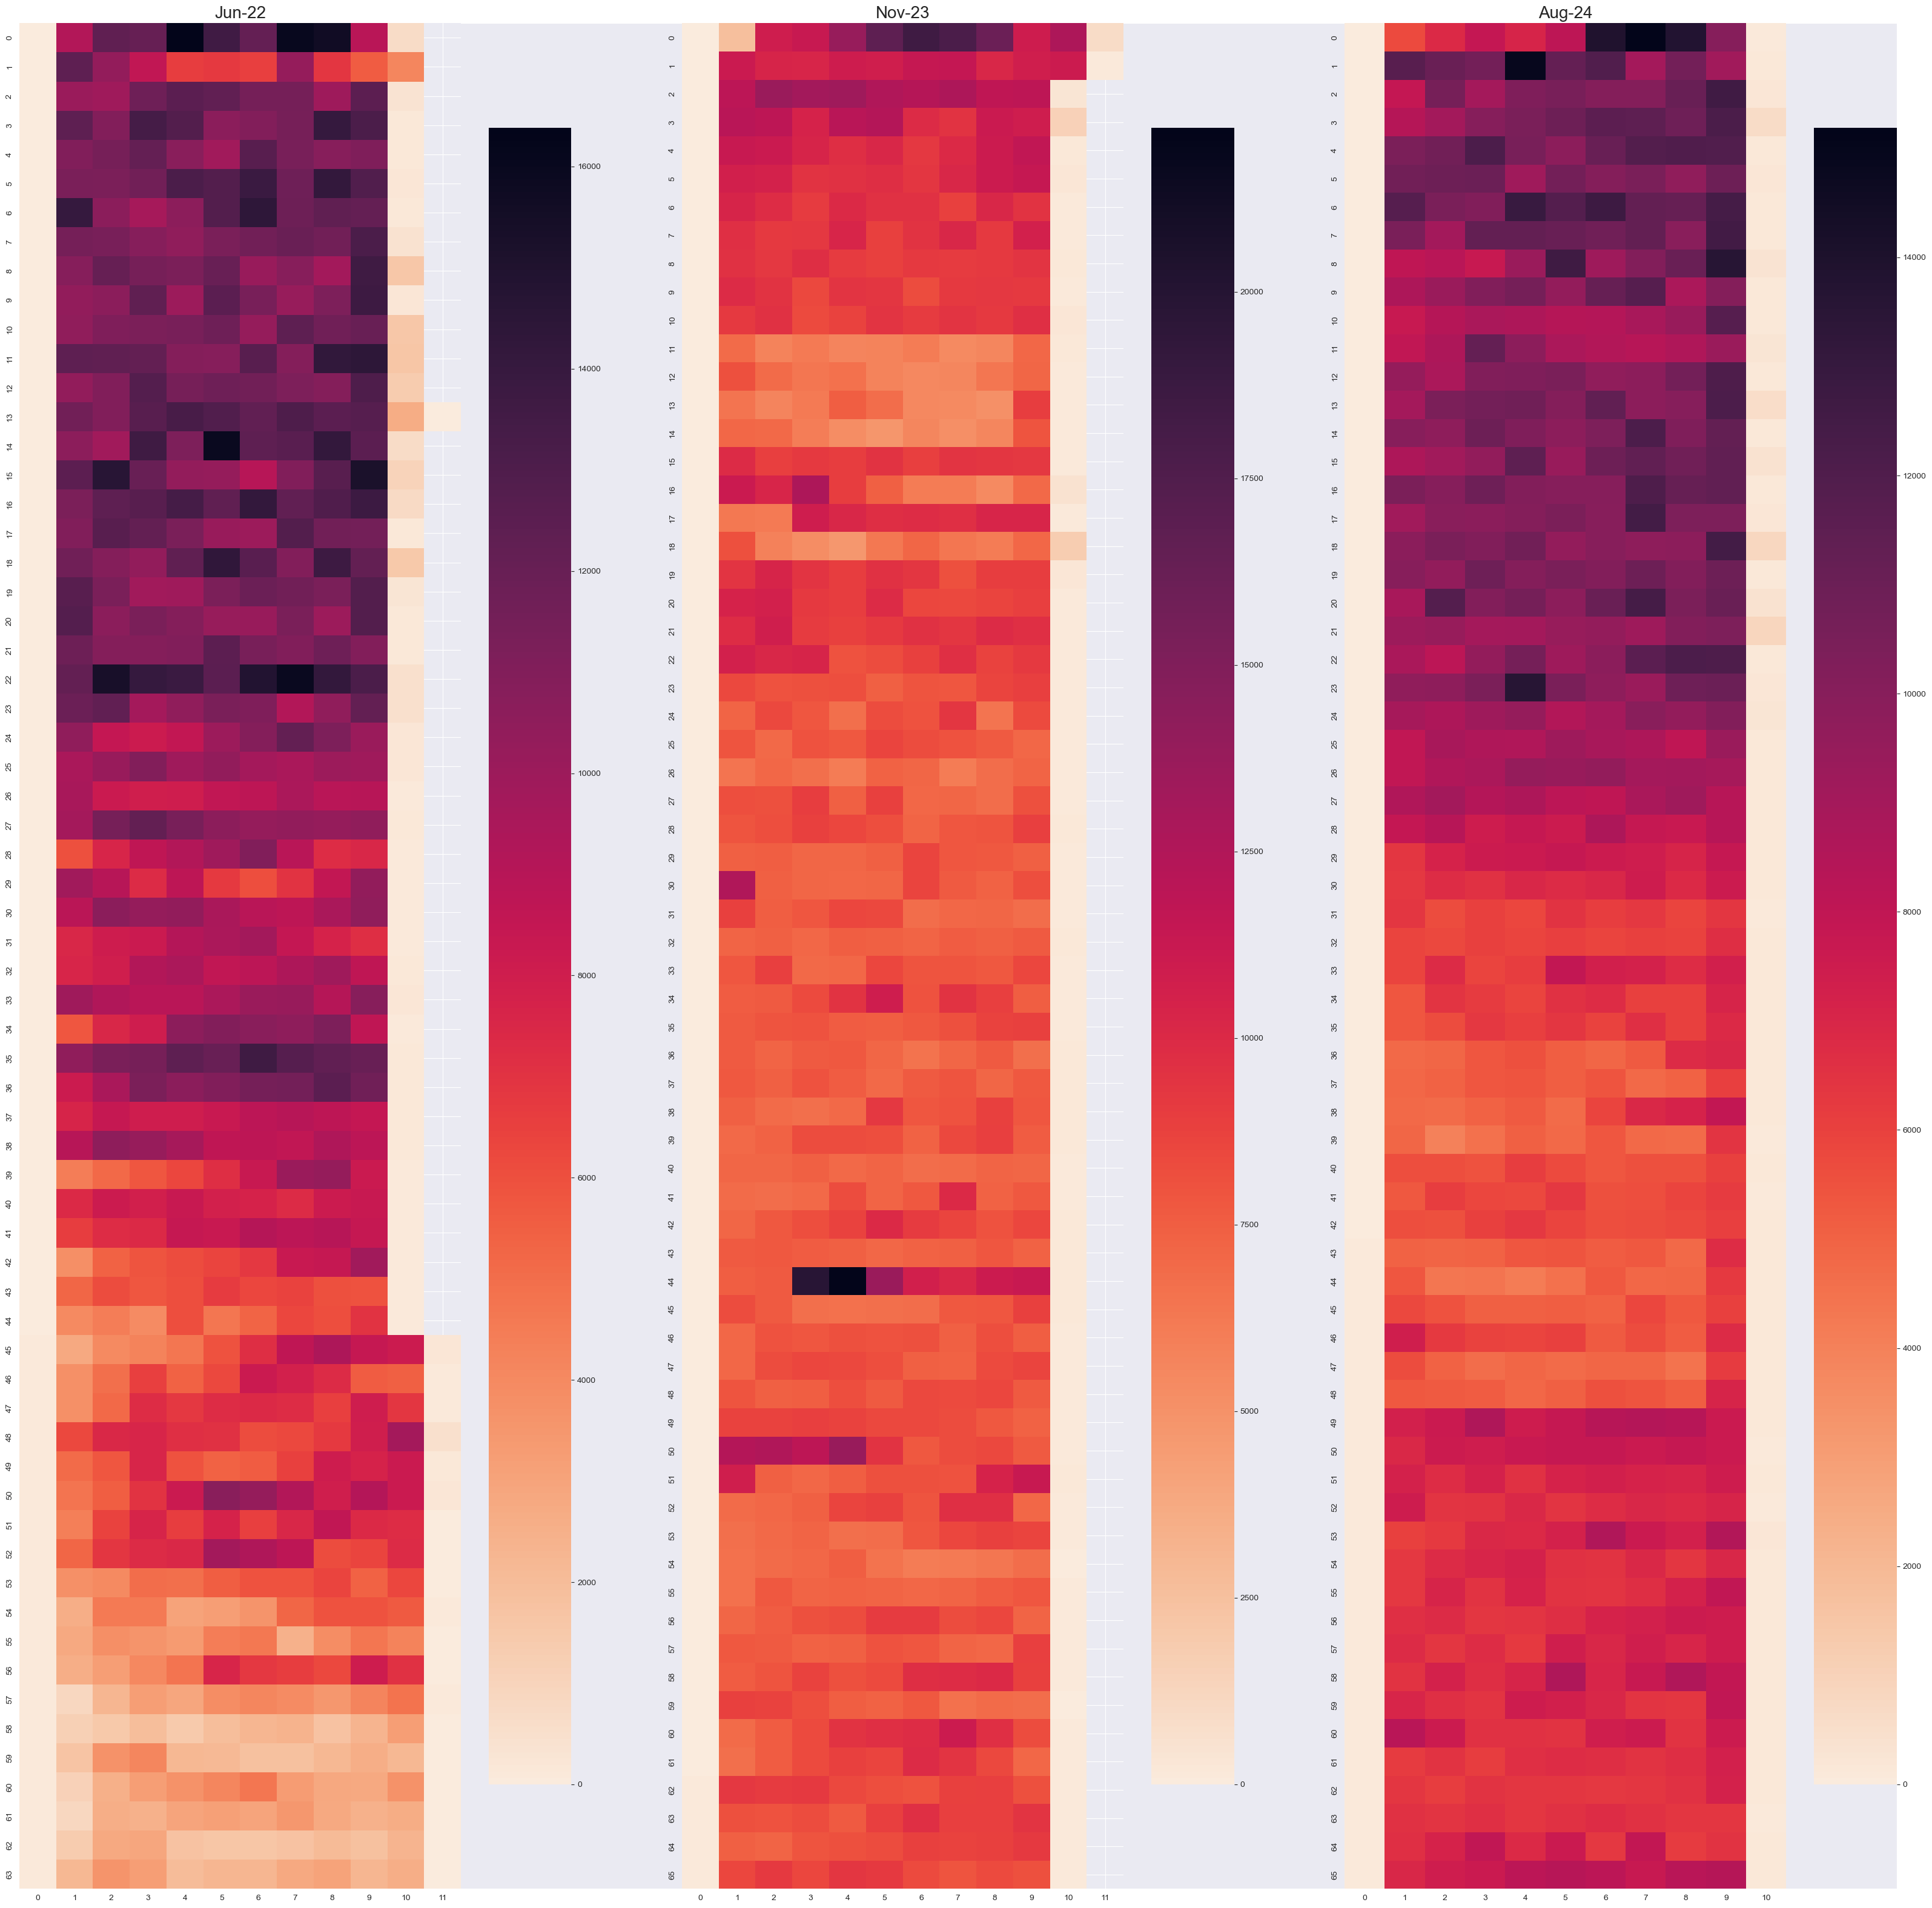

In [3]:
plt.figure(figsize=(40,40))
plt.xticks([])
plt.yticks([])
#plt.title("Traded Volume")
gs = GridSpec(1, 3)

dfs = []
prods = ['Jun-22', 'Nov-23', 'Aug-24']
for prod in prods:
    df_prod = df.filter(pl.col('prod') == prod).filter((pl.col('hour')>6) & (pl.col('hour')<18)).group_by(['hour', 'days_to_roll']).agg(pl.col('total_quantity').sum().alias('quantity')).with_columns(
        pl.col('hour').cast(pl.Utf8).str.zfill(2) 
    ).sort('days_to_roll')
    df_prod = df_prod.pivot(index='days_to_roll', on='hour', values='quantity', sort_columns=True, maintain_order=True)
    dfs.append(df_prod)


# Create subplots using the grid
ax1 = plt.subplot(gs[0, 0])
ax1.title.set_text(prods[0])
ax1.title.set_size(20)
ax2 = plt.subplot(gs[0, 1])
ax2.title.set_text(prods[1])
ax2.title.set_size(20)
ax3 = plt.subplot(gs[0, 2])
ax3.title.set_text(prods[2])
ax3.title.set_size(20)

sns.heatmap(ax=ax1, data=dfs[0], annot=False, cmap = "rocket_r")
sns.heatmap(ax=ax2, data=dfs[1], annot=False, cmap = "rocket_r")
sns.heatmap(ax=ax3, data=dfs[2], annot=False, cmap = "rocket_r")

plt.show()

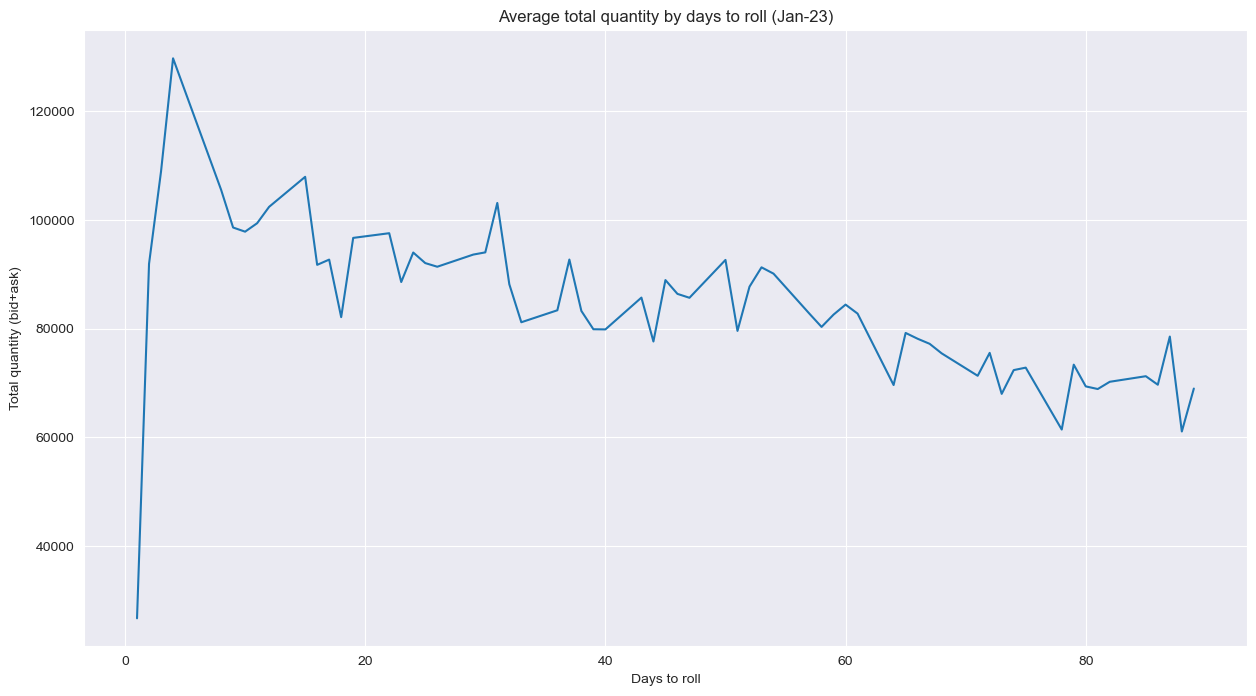

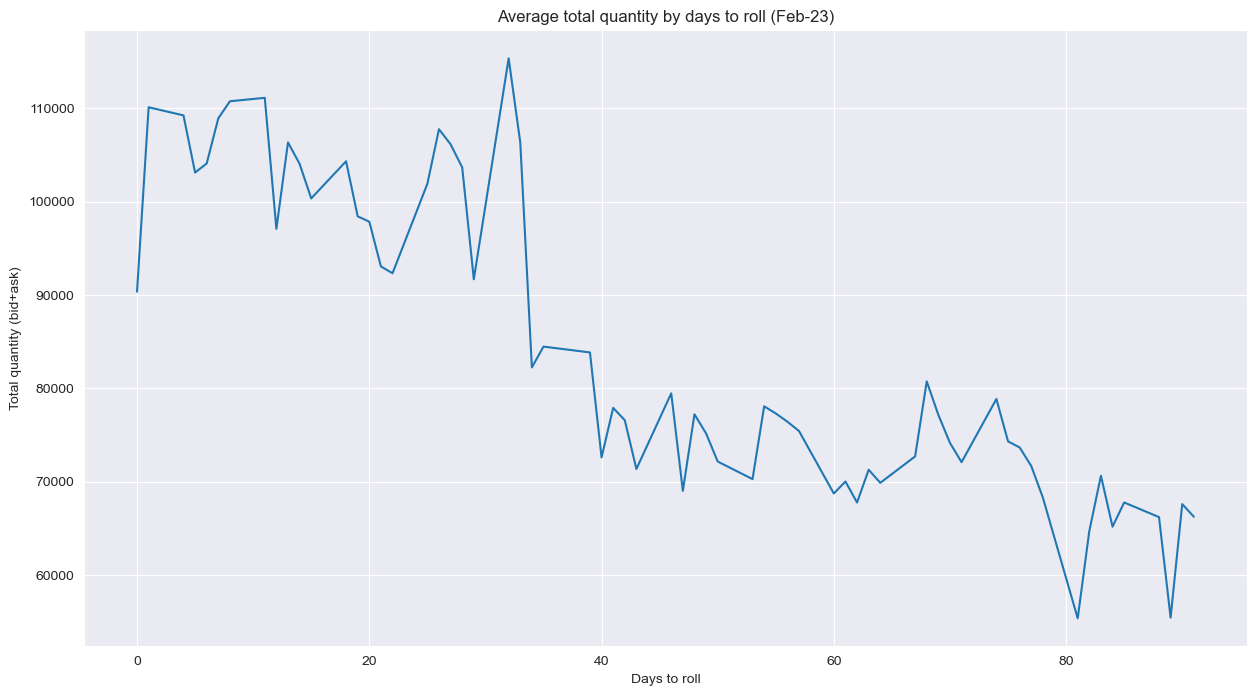

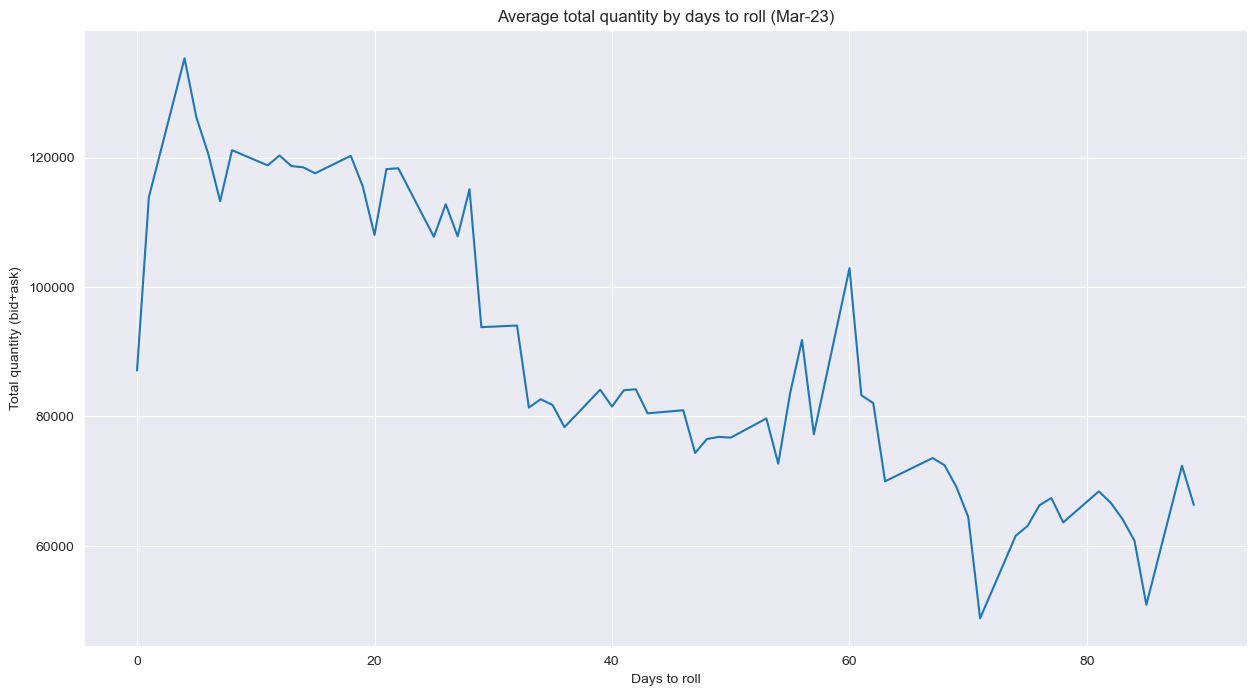

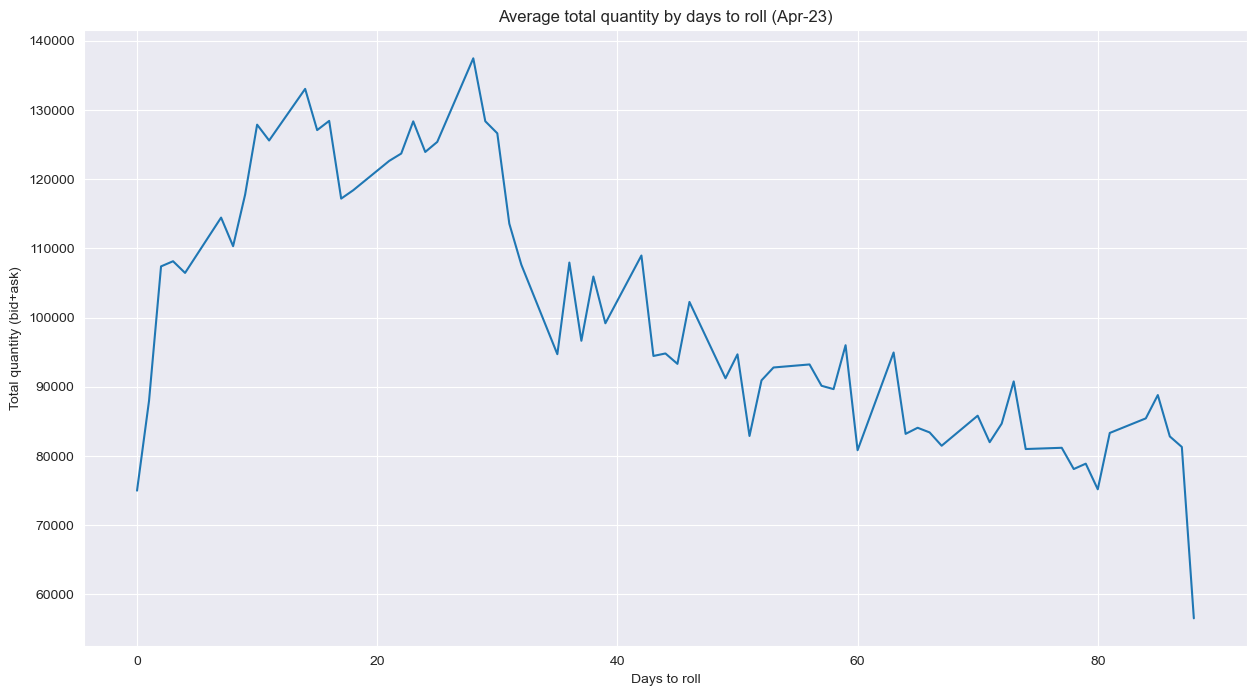

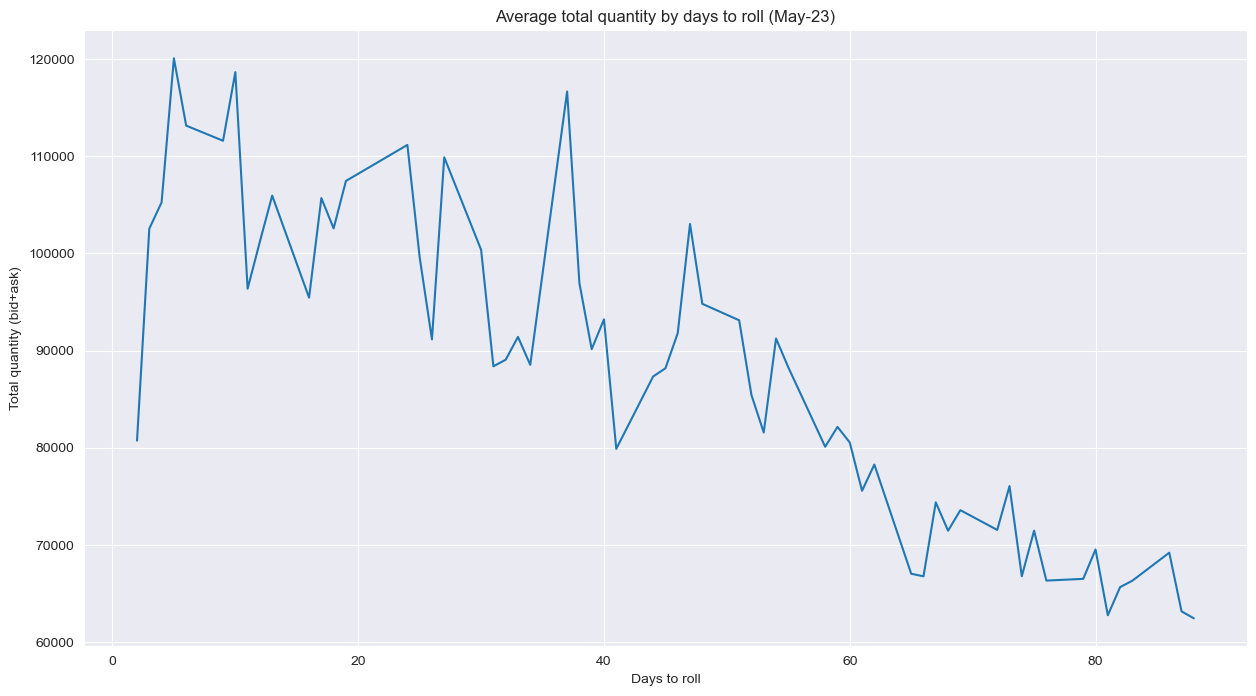

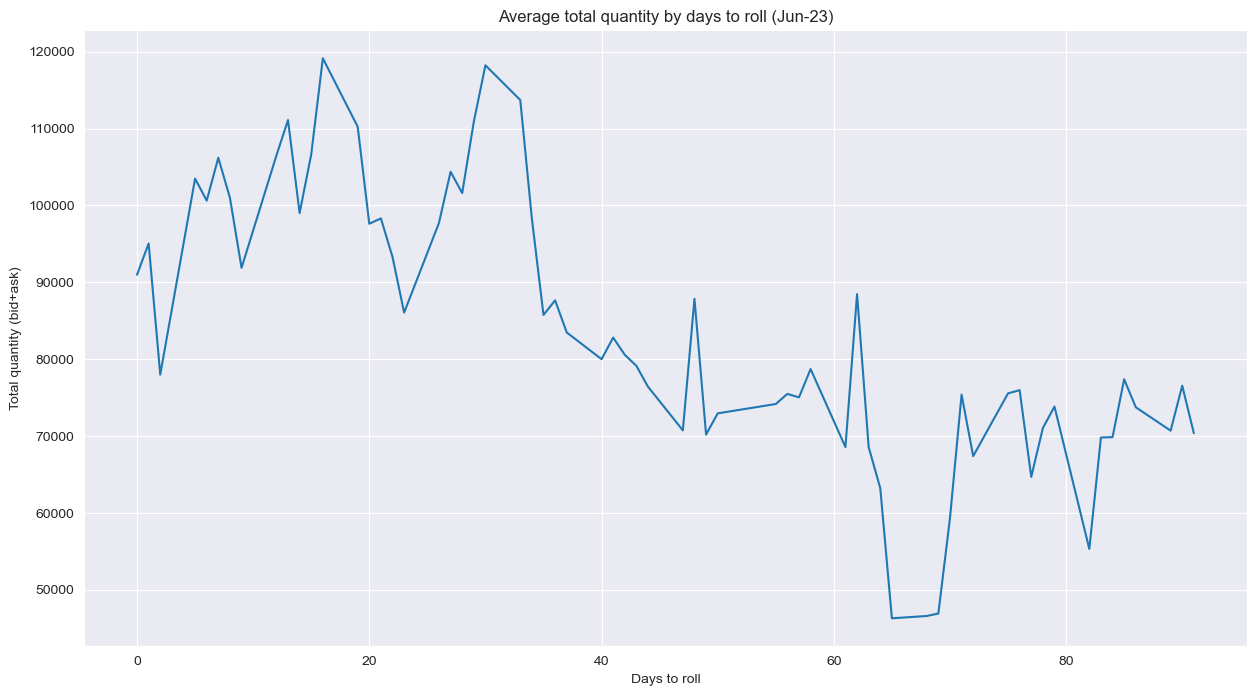

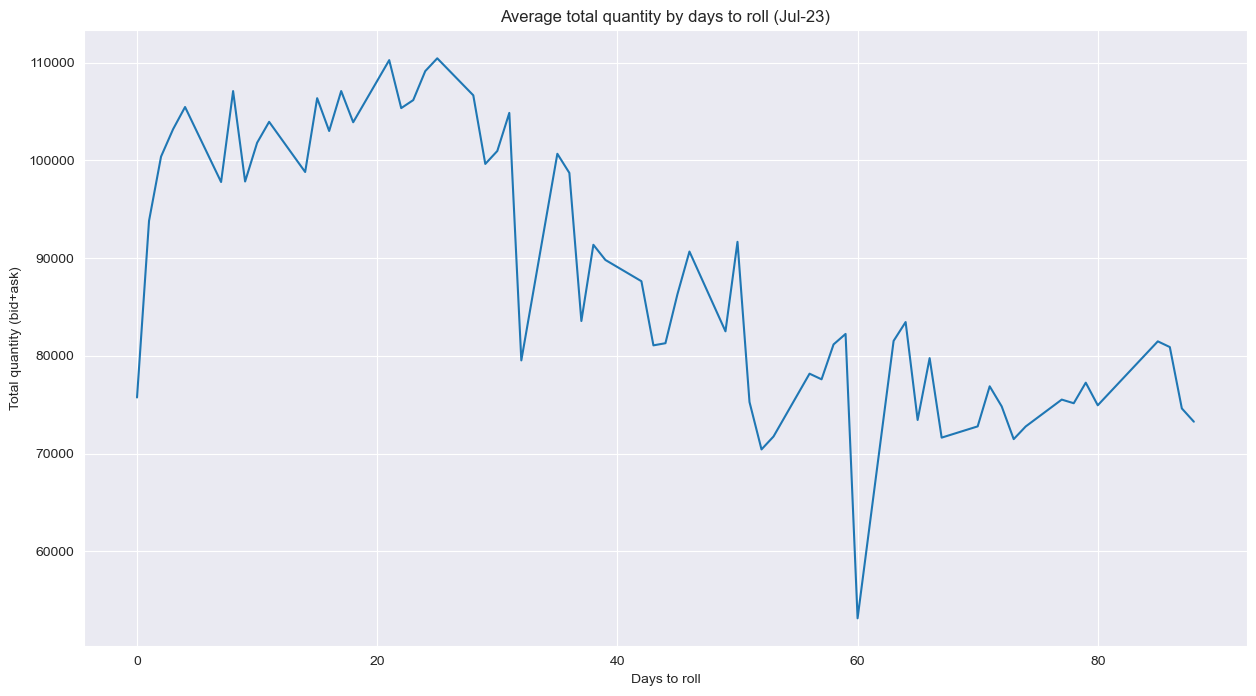

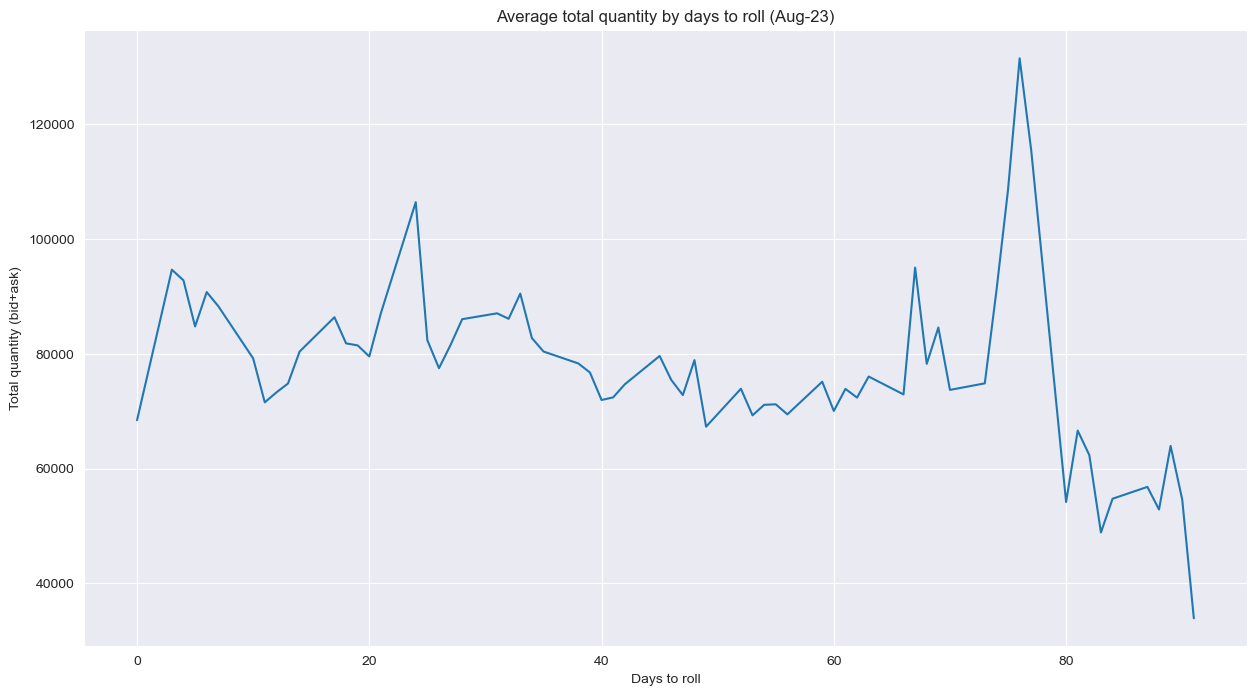

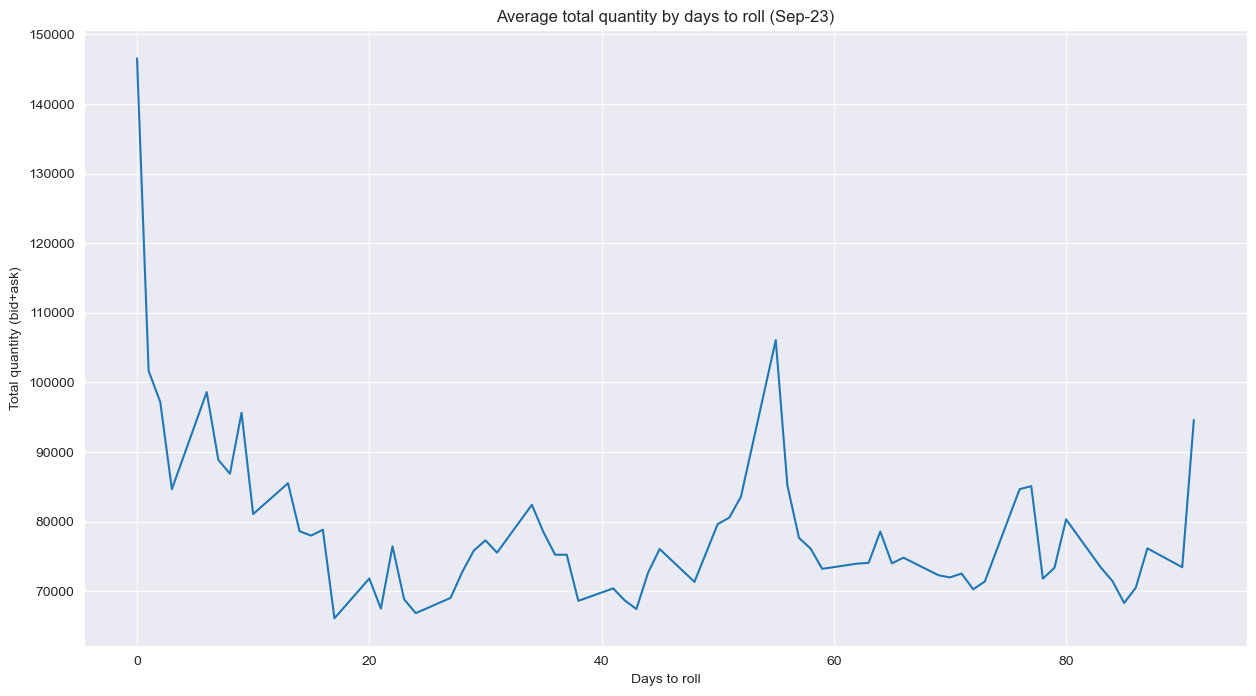

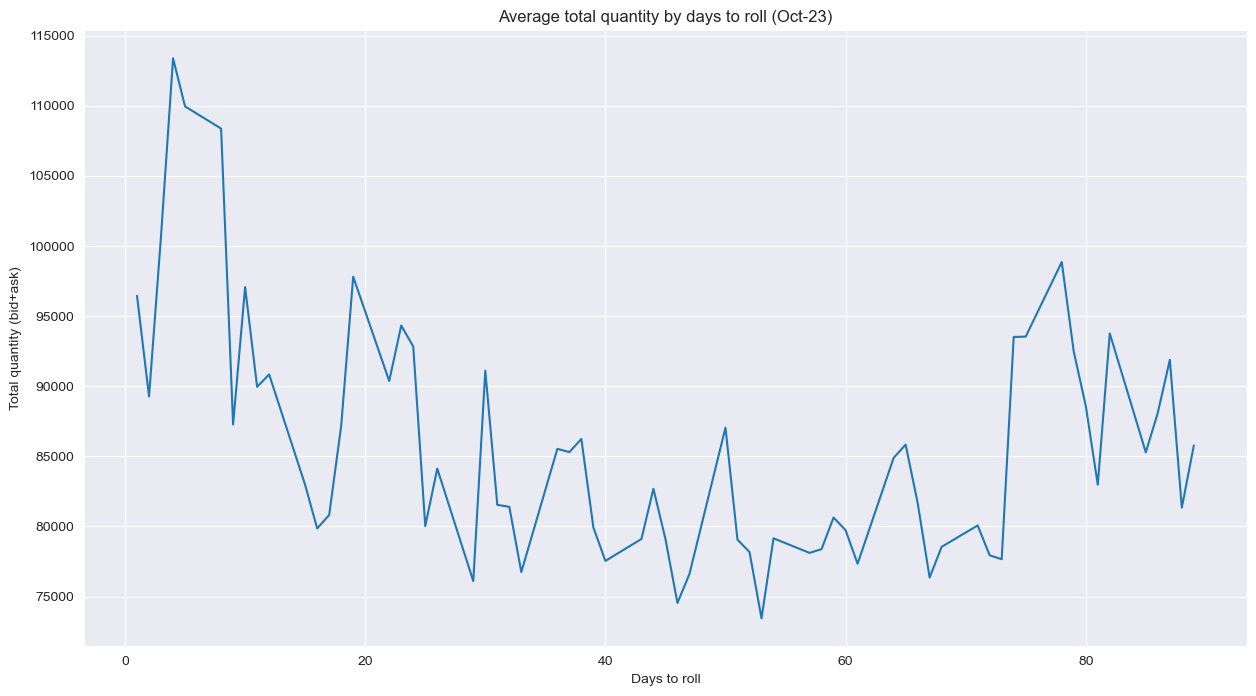

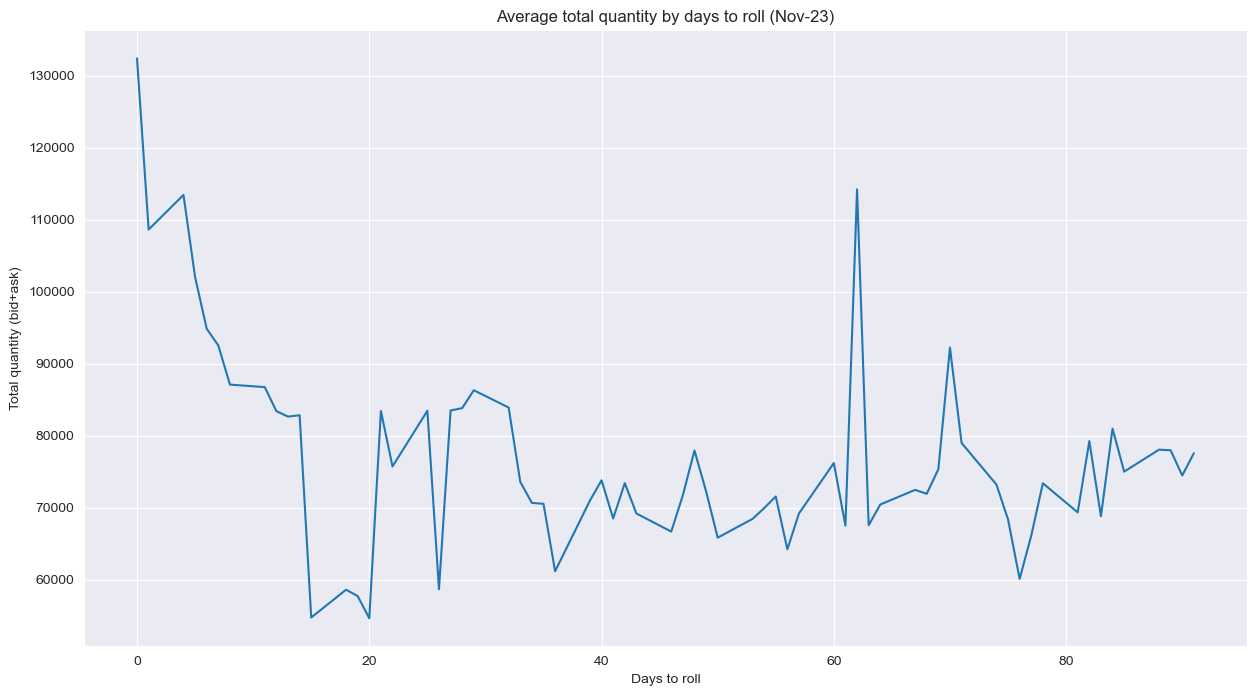

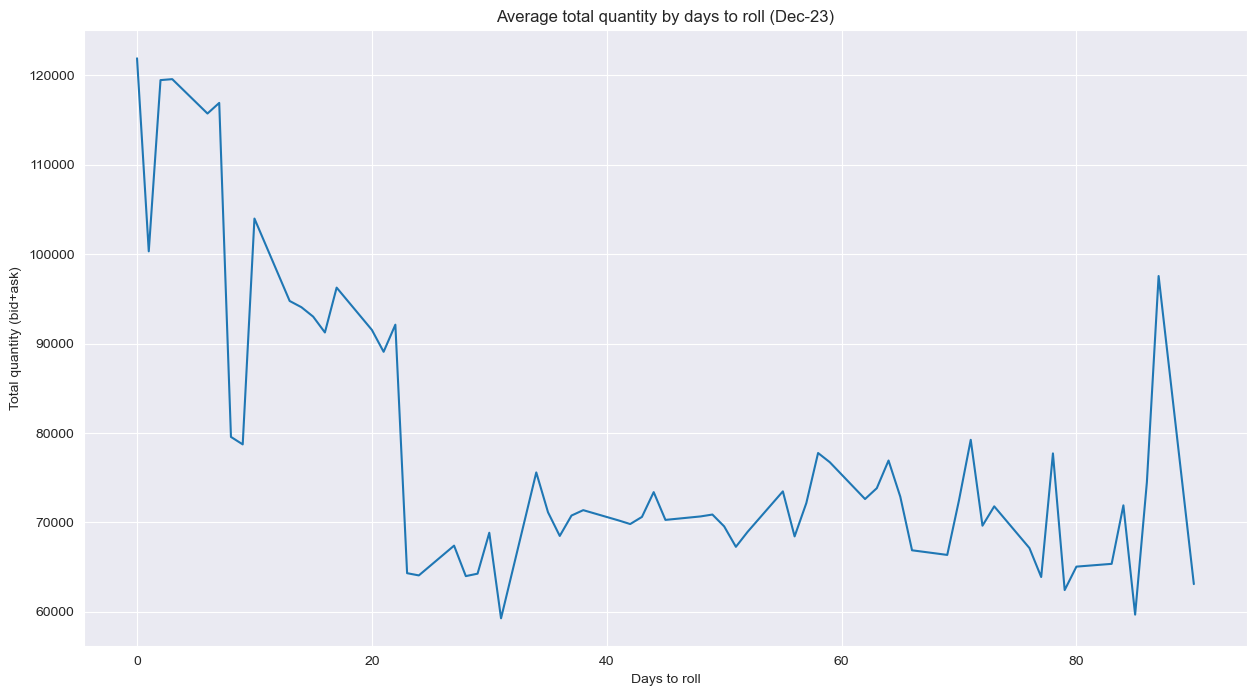

In [4]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year = '-23'
prods = [month + year for month in months]

for prod in prods:   
    df_aug24 = df.filter(pl.col('prod') == prod).filter((pl.col('hour')>6) & (pl.col('hour')<18)).group_by(['days_to_roll']).agg(pl.col('total_quantity').sum().alias('quantity')).sort(['days_to_roll'])
    
    roll = df_aug24['days_to_roll'].to_list()
    quantity = df_aug24['quantity'].to_list()
    
    plt.figure(figsize=(8, 4))
    plt.plot(roll, quantity)
    plt.xlabel('Days to roll')
    plt.ylabel('Total quantity (bid+ask)')
    plt.title(f'Average total quantity by days to roll ({prod})')
    plt.show()